## Imports

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import os

# part 1

## Get the data

In [3]:
df = pd.read_csv('GooglePlay.csv')
# print(df)
# df_test = pd.read_csv('heart_attack_prediction_dataset.csv')
# list(df['Last Updated'].value_counts().keys())
# df.loc[:,'Category']
# list(df['Content Rating'].value_counts().keys())
# l = []
# for i in df['Genres'].value_counts().keys():
#     l+= i.split(';')
# set(l)
# df[df['Content Rating'] == 'Adults only 18+']
# df['Installs'].value_counts()
# df.iloc[100:160]
# df 


## Get All data

In [4]:
df1 = pd.read_csv('source_Playstore_final.csv')


C:\Users\new\AppData\Local\Temp\ipykernel_20328\3051233106.py:1: DtypeWarning: Columns (7,12,29,30,33,35,37,38,40,42,43,44,46,47,48,49,50,52,53) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('source_Playstore_final.csv')


## check dataset playstore

In [15]:
# df1.iloc[100:160]
# list(df1['Developer Email'].value_counts().keys())
# df.loc[:,'Category']
# df1['Category'].value_counts()
# unique_keys = set(df1['App Id'].value_counts().keys())

# l = []
# for i in df['Genres'].value_counts().keys():
#     l+= i.split(';')
# set(l)
# df[df['Content Rating'] == 'Adults only 18+']
# df['Installs'].value_counts()
# df.iloc[100:160]
# unique_keys
# df1.columns
list(df1['Minimum Installs'].value_counts().keys())


[10000.0,
 1000.0,
 100000.0,
 100.0,
 5000.0,
 50000.0,
 500.0,
 10.0,
 1000000.0,
 500000.0,
 50.0,
 10000000.0,
 5000000.0,
 5.0,
 1.0,
 0.0,
 50000000.0,
 100000000.0,
 500000000.0,
 1000000000.0,
 5000000000.0,
 10000000000.0]

## prepare numerical data

In [88]:
# get numerical columns
columns = df.columns
numerical_columns = {"Rating": df['Rating'],
                     "Reviews": df['Reviews'],
                     "Size": df['Size'],
                     "Installs": df['Installs'],
                     "Price": df['Price']}
# we will extract the numbers and store the cleaned data in the dict below
cleaned_numerical_columns = {}
# drop missing data = NoN rows
for col in numerical_columns.keys():
    numerical_columns[col].dropna(inplace=True)

## check what is the structure of data in each column

In [6]:
for col_name in numerical_columns.keys():
    data_without_digits = np.array([])
    for data in numerical_columns[col_name]:
        data_without_digits = np.append(data_without_digits, re.sub(r'\d+', '', str(data)))

    # save each structure once
    data_without_digits = np.unique(data_without_digits)
    print(f"column <{col_name}>, extera characters:", data_without_digits, end='\n')

column <Rating>, extera characters: ['.']
column <Reviews>, extera characters: ['']
column <Size>, extera characters: ['.M' '.k' 'M' 'Varies with device' 'k']
column <Installs>, extera characters: ['' '+' ',+' ',,+' ',,,+']
column <Price>, extera characters: ['' '$. ']


## Add 'Rating' and 'Review' columns in cleaned_numerical_columns, because they're already clean

In [7]:
cleaned_numerical_columns['Rating'] = numerical_columns['Rating']
cleaned_numerical_columns['Reviews'] = numerical_columns['Reviews']

## 'Size' column: Remove not numerical data

In [8]:
pattern = r'^\d+(\.\d+)?[Mk]$'
for index, data in enumerate(numerical_columns['Size']):
    if not (re.match(pattern, data)):
        numerical_columns['Size'].drop(index, inplace=True)

## 'Size' column: Extract numbers from combined data

In [9]:
def convert_to_integer(data):
    if data.endswith('M'):
        return int(float(data[:-1]) * 1e6)  # Convert M to millions
    elif data.endswith('k'):
        return int(float(data[:-1]) * 1e3)  # Convert k to thousands
    else:
        return int(data)


# convert combined data into integer
cleaned_numerical_columns['Size'] = numerical_columns['Size'].apply(convert_to_integer)

## 'Installs' column: remove extra characters like ',' and '+'

In [10]:
cleaned_numerical_columns['Installs'] = numerical_columns['Installs'].apply(
    lambda x: int(''.join(filter(str.isdigit, x))))

## 'Price' column: remove $

In [11]:
cleaned_numerical_columns['Price'] = numerical_columns['Price'].apply(lambda x: float(x.replace('$', '')))

## analyse columns

In [12]:
# create a dict to store mean, max,... values for each attr
analyse_attrs = {key: [] for key in cleaned_numerical_columns.keys()}

for key in cleaned_numerical_columns.keys():
    # get the data of a column/attr
    data = cleaned_numerical_columns[key]
    attr_name = key
    attr_type = type(data[0])
    value_range = (data.min(), data.max())
    min_val = data.min()
    max_val = data.max()
    mean_val = data.mean()
    mode_val = data.mode()[0]
    median_val = data.median()
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = data[(data < lower_bound) | (data > upper_bound)].tolist()
    analyse_attrs[key] = [attr_name, attr_type, value_range, min_val, max_val, mean_val, mode_val, median_val, outliers]

In [13]:
# save the result dataframe
labels = ['attr_name', 'attr_type', 'value_range', 'min_val', 'max_val', 'mean_val', 'mode_val', 'median_val',
          'outliers']
analyse_attrs = pd.DataFrame(analyse_attrs, index=labels)
analyse_attrs.T.to_csv('part1_analyse_attrs.csv', index=False)
analyse_attrs.T

,attr_name,attr_type,value_range,min_val,max_val,mean_val,mode_val,median_val,outliers
Rating,Rating,<class 'numpy.float64'>,"(1.0, 5.0)",1.0,5.0,4.191757,4.4,4.3,"[3.2, 3.2, 3.1, 3.2, 3.2, 2.6, 3.1, 3.0, 1.9, ..."
Reviews,Reviews,<class 'numpy.int64'>,"(0, 78158306)",0,78158306,444152.896033,0,2094.0,"[215644, 194216, 224399, 295221, 174531, 27192..."
Size,Size,<class 'numpy.int64'>,"(8500, 100000000)",8500,100000000,21516529.515582,11000000,13000000.0,"[73000000, 77000000, 70000000, 77000000, 84000..."
Installs,Installs,<class 'numpy.int64'>,"(0, 1000000000)",0,1000000000,15464338.882565,1000000,100000.0,"[50000000, 100000000, 100000000, 1000000000, 5..."
Price,Price,<class 'numpy.float64'>,"(0.0, 400.0)",0.0,400.0,1.027368,0.0,0.0,"[4.99, 4.99, 4.99, 4.99, 3.99, 3.99, 6.99, 1.4..."


## BoxPlot for outliers

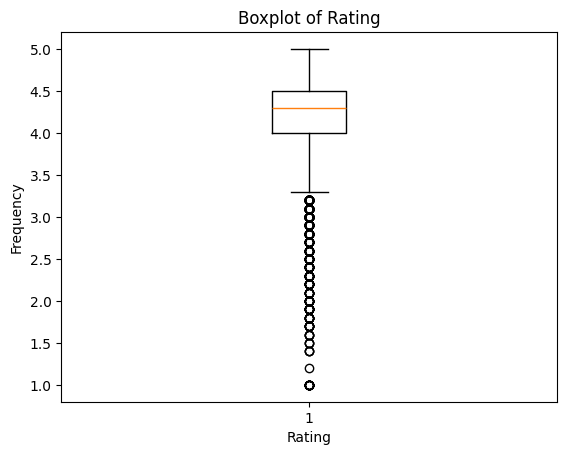

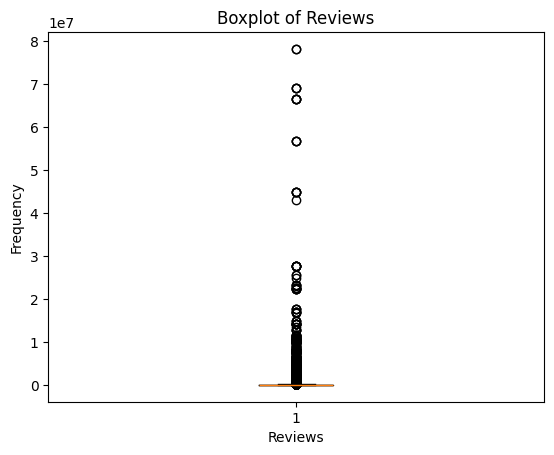

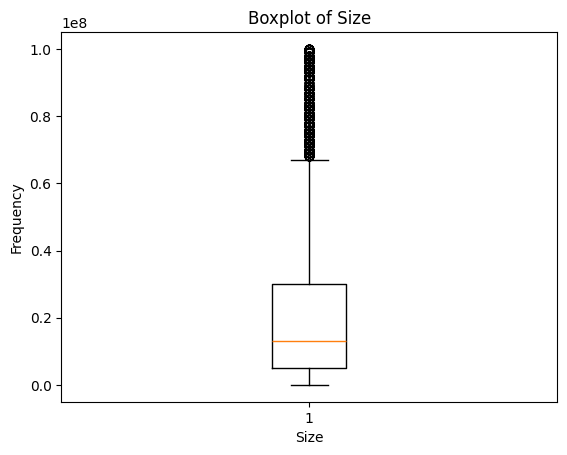

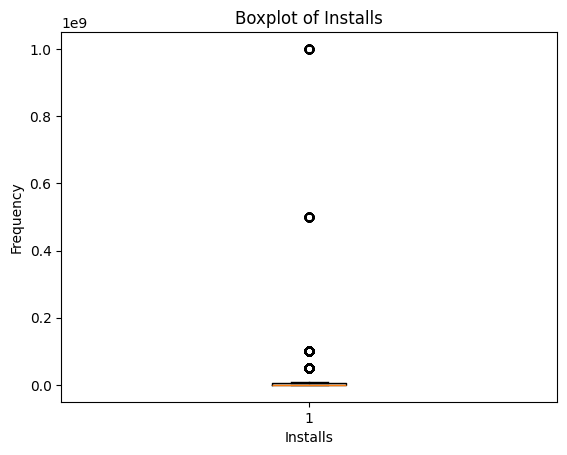

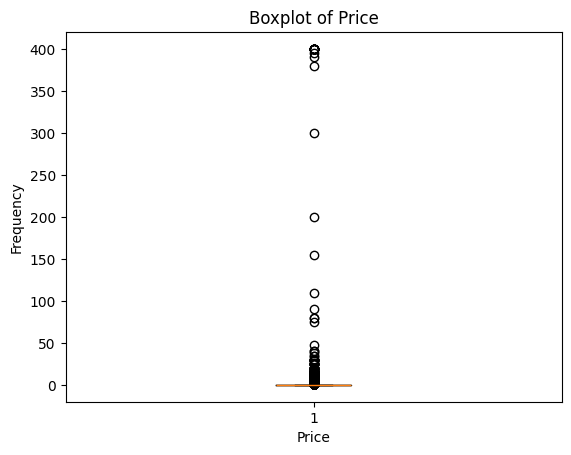

In [14]:
# Check if the directory 'boxPlots' exists, and create it if it doesn't
directory = 'part1_boxPlots'
if not os.path.exists(directory):
    os.makedirs(directory)
# make boxPlots
for key in cleaned_numerical_columns.keys():
    # get a column of data
    data = cleaned_numerical_columns[key]
    # create boxplot
    plt.boxplot(data)
    # Add labels and title
    plt.xlabel(key)
    plt.ylabel('Frequency')
    plt.title(f'Boxplot of {key}')
    plt.savefig(f'part1_boxPlots/boxplot_{key}.png')
    plt.show()

## Quality table dataset googleplay

In [6]:
quality_table = pd.DataFrame(index=list(df.columns),
                             columns=["No.records", "No.Null", "Accuracy", "Completeness", "Validity", "Currentness",
                                      "Consistency"])
columns_to_check = df.columns

## Quality table dataset playstore

In [7]:
quality_table1 = pd.DataFrame(index=list(df1.columns),
                              columns=["No.records", "No.Null", "Accuracy", "Completeness", "Validity", "Currentness",
                                       "Consistency"])
columns_to_check1 = df1.columns

## Number of record dataset google paly

In [106]:
for column in columns_to_check:
    quality_table['No.records'][column] = len(df)
# quality_table  

C:\Users\new\AppData\Local\Temp\ipykernel_11592\4058203837.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  quality_table['No.records'][column] = len(df)


## Nunmber of record dataset playstore

In [8]:
for column in columns_to_check1:
    quality_table1['No.records'][column] = len(df1)
# quality_table  

C:\Users\new\AppData\Local\Temp\ipykernel_20328\2016229688.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  quality_table1['No.records'][column] = len(df1)


## Missing value dataset googleplay

In [9]:
missing_values = {}
for column in columns_to_check:
    missing_values[column] = df[df[column].isna()]

## Missing value dataset playstore

In [10]:
missing_values1 = {}
for column in columns_to_check1:
    missing_values1[column] = df1[df1[column].isna()]


## Invalid value dataset googleplay

In [111]:
def pattern_validation(inp, pattern):
    return inp.str.match(pattern)


def boundary_validation(inp, start, end):
    return ((inp >= start) & (inp <= end))


def isin_validation(inp, range):
    return inp.isin(range)


df['Current Ver'] = df['Current Ver'].astype(str)
df['Android Ver'] = df['Android Ver'].astype(str)
df['Last Updated'] = df['Last Updated'].astype(str)
# df['Price'] = df['Price'].astype(str)
invalid_values = {}
for column in columns_to_check:
    if column == 'Category':
        new_df = df[df['Category'].notna()]
        invalid_values[column] = new_df[~isin_validation(new_df['Category'],
                                                         ['FAMILY', 'GAME', 'TOOLS', 'MEDICAL', 'BUSINESS',
                                                          'PRODUCTIVITY', 'PERSONALIZATION', 'COMMUNICATION', 'SPORTS',
                                                          'LIFESTYLE', 'FINANCE', 'HEALTH_AND_FITNESS', 'PHOTOGRAPHY',
                                                          'SOCIAL', 'NEWS_AND_MAGAZINES', 'SHOPPING',
                                                          'TRAVEL_AND_LOCAL', 'DATING', 'BOOKS_AND_REFERENCE',
                                                          'VIDEO_PLAYERS', 'EDUCATION', 'ENTERTAINMENT',
                                                          'MAPS_AND_NAVIGATION', 'FOOD_AND_DRINK', 'HOUSE_AND_HOME',
                                                          'AUTO_AND_VEHICLES', 'LIBRARIES_AND_DEMO', 'WEATHER',
                                                          'ART_AND_DESIGN', 'EVENTS', 'PARENTING', 'COMICS', 'BEAUTY'])]
    elif column == 'Rating':
        new_df = df[df['Rating'].notna()]
        invalid_values[column] = new_df[~boundary_validation(new_df['Rating'], 0, 5)]
    elif column == 'Reviews':
        new_df = df[df['Reviews'].notna()]
        invalid_values[column] = new_df[~boundary_validation(new_df['Reviews'], 0, np.inf)]
    elif column == 'Size':
        new_df = df[df['Size'].notna()]
        invalid_values[column] = new_df[~pattern_validation(new_df['Size'], '[0-9]')]
    elif column == 'Content Rating':
        new_df = df[df['Content Rating'].notna()]
        invalid_values[column] = new_df[~isin_validation(new_df['Content Rating'],
                                                         ['Everyone', 'Teen', 'Mature 17+', 'Everyone 10+',
                                                          'Adults only 18+', 'Unrated'])]
    elif column == 'Genres':
        new_df = df[df['Genres'].notna()]
        invalid_values[column] = new_df[~pattern_validation(new_df['Genres'], '^[\w\s&;]+$')]
    elif column == 'Last Updated':
        new_df = df[df['Last Updated'].notna()]
        invalid_values[column] = new_df[~pattern_validation(new_df['Last Updated'], '[0-9]{2}-[A-Z][a-z]{2}-[0-9]{2}')]
    elif column == 'Current Ver':
        new_df = df[df['Current Ver'].notna()]
        invalid_values[column] = new_df[~pattern_validation(new_df['Current Ver'], '^\d+(\.\d+)*$')]
    elif column == 'Android Ver':
        new_df = df[df['Android Ver'].notna()]
        invalid_values[column] = new_df[
            ~pattern_validation(new_df['Android Ver'], '\d+(\.\d+)*\s*-\s*\d+(\.\d+)*|\d+(\.\d+)*\s+and\s+up')]
    elif column == 'Type':
        new_df = df[df['Type'].notna()]
        invalid_values[column] = new_df[~isin_validation(new_df['Type'], ['Free', 'Paid'])]
    elif column == 'Installs':
        new_df = df[df['Installs'].notna()]
        invalid_values[column] = new_df[~pattern_validation(new_df['Installs'], '^\d+(,\d+)*\+$|0')]
    elif column == 'Price':
        new_df = df[df['Price'].notna()]
        invalid_values[column] = new_df[~pattern_validation(new_df['Price'], '^\$?\d+(\.\d{2})?|0')]
# invalid_values['Category']

## save each column dataset Googleplay as a CSV 

In [64]:
testdf = pd.DataFrame(invalid_values['Price'])
testdf.to_csv('invalid_value_googlepaly\Price.csv')

## Invalid value dataset playstore

In [113]:
def pattern_validation(inp, pattern):
    return inp.str.match(pattern)


def boundary_validation(inp, start, end):
    return ((inp >= start) & (inp <= end))


def isin_validation(inp, range):
    return inp.isin(range)


invalid_values1 = {}
df1['Size'] = df1['Size'].astype(str)
df1['Minimum Android'] = df1['Minimum Android'].astype(str)
df1['Developer Id'] = df1['Developer Id'].astype(str)
df1['Developer Internal ID'] = df1['Developer Internal ID'].astype(str)
df1['Developer Website'] = df1['Developer Website'].astype(str)
df1['Developer Email'] = df1['Developer Email'].astype(str)

for column in columns_to_check1:
    if column == 'Category':
        new_df1 = df1[df1[column].notna()]
        invalid_values1[column] = new_df1[~isin_validation(new_df1[column], ['Education', 'Tools', 'Books & Reference',
                                                                             'Personalization', 'Music & Audio',
                                                                             'Entertainment', 'Lifestyle', 'Business',
                                                                             'Productivity', 'Health & Fitness',
                                                                             'Puzzle', 'Travel & Local', 'Casual',
                                                                             'Photography', 'Sports', 'Finance',
                                                                             'Simulation', 'News & Magazines', 'Arcade',
                                                                             'Shopping', 'Food & Drink',
                                                                             'Communication', 'Action', 'Educational',
                                                                             'Social', 'Medical', 'Adventure',
                                                                             'Maps & Navigation', 'Role Playing',
                                                                             'Video Players & Editors', 'Art & Design',
                                                                             'Racing', 'Board', 'Strategy', 'Card',
                                                                             'Word', 'Auto & Vehicles', 'Weather',
                                                                             'Trivia', 'House & Home', 'Beauty',
                                                                             'Dating', 'Casino', 'Libraries & Demo',
                                                                             'Events', 'Music', 'Parenting', 'Comics'])]
    elif column == 'Rating':
        new_df1 = df1[df1[column].notna()]
        invalid_values1[column] = new_df1[~boundary_validation(new_df1[column], 0, 5)]
    elif column == 'Rating Count':
        new_df1 = df1[df1[column].notna()]
        invalid_values1[column] = new_df1[~boundary_validation(new_df1[column], 0, np.inf)]
    elif column == 'Installs':
        new_df1 = df1[df1[column].notna()]
        invalid_values1[column] = new_df1[~pattern_validation(new_df1[column], '^\d+(,\d+)*\+$|0')]
    elif column == 'Minimum Installs':
        new_df1 = df1[df1[column].notna()]
        invalid_values1[column] = new_df1[~boundary_validation(new_df1[column], 0, np.inf)]
    elif column == 'Free':
        new_df1 = df1[df1[column].notna()]
        invalid_values1[column] = new_df1[~isin_validation(new_df1[column], ['False', 'True'])]
    elif column == 'Price':
        new_df1 = df1[df1[column].notna()]
        invalid_values1[column] = new_df1[~boundary_validation(new_df1[column], 0, np.inf)]
    elif column == 'Currency':
        new_df1 = df1[df1[column].notna()]
        invalid_values1[column] = new_df1[~isin_validation(new_df1[column],
                                                           ['USD', 'XXX', 'EUR', 'INR', 'GBP', 'PKR', 'THB', 'HKD',
                                                            'TRY', 'RUB', 'VND', 'BDT', 'BGN', 'KRW', 'IDR', 'UAH',
                                                            'CAD', 'AUD', 'SGD', 'JPY', 'RSD', 'ZAR', 'PEN', 'PLN',
                                                            'ILS', 'CHF', 'AED', 'BRL', 'DKK', 'NGN', 'KES', 'CZK',
                                                            'MYR', 'EGP', 'NZD', 'TWD', 'SEK', 'MXN', 'LKR', 'HUF',
                                                            'KZT', 'COP', 'DZD', 'LBP', 'TZS', 'GHS', 'BOB'])]
    elif column == 'Size':
        new_df1 = df1[df1[column].notna()]
        invalid_values1[column] = new_df1[~pattern_validation(new_df1[column], '^\d+(\.\d+)?[MK]$')]
    elif column == 'Minimum Android':
        new_df1 = df1[df1[column].notna()]
        invalid_values1[column] = new_df1[~pattern_validation(new_df1[column], '^\d+(\.\d+)*$|4.4W')]
    elif column == 'Developer Id':
        new_df1 = df1[df1[column].notna()]
        invalid_values1[column] = new_df1[isin_validation(new_df1[column], ['nan'])]
    elif column == 'Developer Website':
        new_df1 = df1[df1[column].notna()]
        invalid_values1[column] = new_df1[~pattern_validation(new_df1[column], '^(?:[Hh][Tt][Tt][Pp][Ss]?://)[^\s]+')]
    elif column == 'Developer Email':
        new_df1 = df1[df1[column].notna()]
        invalid_values1[column] = new_df1[
            ~pattern_validation(new_df1[column], '[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2}(?:\.[A-Za-z]{2})?')]
    elif column == 'Released' or column == 'Last update':
        new_df1 = df1[df1[column].notna()]
        invalid_values1[column] = new_df1[
            ~pattern_validation(new_df1[column], '\d{1,2}-(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)-\d{2}')]
    elif column == 'Privacy Policy':
        new_df1 = df1[df1[column].notna()]
        invalid_values1[column] = new_df1[~pattern_validation(new_df1[column], '^(?:[Hh][Tt][Tt][Pp][Ss]?://)[^\s]+')]
    elif column == 'Content Rating':
        new_df1 = df1[df1[column].notna()]
        invalid_values1[column] = new_df1[~isin_validation(new_df1[column],
                                                           ['Everyone', 'Teen', 'Mature 17+', 'Everyone 10+',
                                                            'Adults only 18+', 'Unrated'])]
    elif column == 'Ad Supported' or column == 'In app purchases' or column == 'Editor Choice':
        new_df1 = df1[df1[column].notna()]
        invalid_values1[column] = new_df1[~isin_validation(new_df1[column], [True, False])]
    elif column == 'Reviews':
        new_df1 = df1[df1[column].notna()]
        invalid_values1[column] = new_df1[~boundary_validation(new_df1[column], 0, np.inf)]
    elif column == 'Developer Internal ID':
        new_df1 = df1[df1[column].notna()]
        invalid_values1[column] = new_df1[~pattern_validation(new_df1[column], '^\d\.\d+[Ee]\+\d+')]
    elif column == 'Android version Text':
        new_df1 = df1[df1[column].notna()]
        invalid_values1[column] = new_df1[
            ~pattern_validation(new_df1[column], '^(?:\d+(\.\d+)*\s?(?:[-_]\s?\d+(\.\d+)*)?\s?(?:and up)?)$')]
        #\d+(\.\d+)*(\s*-\s*\d+(\.\d+)*)?W*(\d+(\.\d+)*)?\s*(and\s*up)?
    elif column == 'Version':
        new_df1 = df1[df1[column].notna()]
        invalid_values1[column] = new_df1[~pattern_validation(new_df1[column], '^\s*\d+(\.\d+)*$')]
# invalid_values1

## save each column dataset Playstore as a CSV 

In [97]:
testdf = pd.DataFrame(invalid_values1['Last update'])
testdf.to_csv('invalid_value_Playstore\Last update1111.csv')

KeyboardInterrupt: 

## Number of Nulls dataset Googleplay

In [115]:
for column in columns_to_check:
    df[column] = df[column].apply(lambda x: np.nan if x == 'nan' else x)
    quality_table['No.Null'][column] = df[column].isnull().sum()

C:\Users\new\AppData\Local\Temp\ipykernel_11592\1924037479.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  quality_table['No.Null'][column] = df[column].isnull().sum()


## Number of Nulls dataset Playstore

In [116]:
for column in columns_to_check1:
    df1[column] = df1[column].apply(lambda x: np.nan if x == 'nan' else x)
    quality_table1['No.Null'][column] = df1[column].isnull().sum()

C:\Users\new\AppData\Local\Temp\ipykernel_11592\3151643143.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  quality_table1['No.Null'][column] = df1[column].isnull().sum()


## Validity of dataset Googleplay

In [118]:
dlen = len(df)

for item in invalid_values:
    quality_table['Validity'][item] = (1 - (len(invalid_values[item].index) / dlen)) * 100
# quality_table


C:\Users\new\AppData\Local\Temp\ipykernel_11592\1393136035.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  quality_table['Validity'][item] = (1-(len(invalid_values[item].index)/dlen)) *100


## Validity of dataset Playstore

In [119]:
dlen = len(df1)
for item in invalid_values1:
    quality_table1['Validity'][item] = (1 - (len(invalid_values1[item].index) / dlen)) * 100

# quality_table1

C:\Users\new\AppData\Local\Temp\ipykernel_11592\279953525.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  quality_table1['Validity'][item] = (1-(len(invalid_values1[item].index)/dlen)) *100


## Completeness of dataset Googleplay

In [121]:
# completeness
dlen = len(df)
for item in missing_values:
    quality_table['Completeness'][item] = (1 - (len(missing_values[item]) / dlen)) * 100
# quality_table

C:\Users\new\AppData\Local\Temp\ipykernel_11592\1499655922.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  quality_table['Completeness'][item] = (1-(len(missing_values[item])/dlen))*100


## Completeness of dataset Playstore

In [122]:
# completeness
dlen = len(df1)
for item in missing_values1:
    quality_table1['Completeness'][item] = (1 - (len(missing_values1[item]) / dlen)) * 100
# quality_table

C:\Users\new\AppData\Local\Temp\ipykernel_11592\2987073027.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  quality_table1['Completeness'][item] = (1-(len(missing_values1[item])/dlen))*100


## Accuracy of dataset Googleplay

In [124]:
dlen = len(df)
for column in columns_to_check:
    if column in missing_values and column in invalid_values:
        accuracy = (1 - ((len(missing_values[column]) + len(invalid_values[column].index.unique())) / dlen)) * 100
        # print(column)
        # print(len(missing_values[column]) + len(invalid_values[column].index))
        # print(dlen)
        # print(accuracy)
        quality_table['Accuracy'][column] = accuracy
    else:
        quality_table['Accuracy'][column] = 100.0  # Assuming completeness if data is not missing or invalid
# quality_table


C:\Users\new\AppData\Local\Temp\ipykernel_11592\334820673.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  quality_table['Accuracy'][column] = 100.0  # Assuming completeness if data is not missing or invalid
C:\Users\new\AppData\Local\Te

## Accuracy of dataset Playstore

In [125]:
dlen = len(df1)
for column in columns_to_check1:
    if column in missing_values1 and column in invalid_values1:
        accuracy = (1 - ((len(missing_values1[column]) + len(invalid_values1[column].index.unique())) / dlen)) * 100
        # print(column)
        # print(len(missing_values[column]) + len(invalid_values[column].index))
        # print(dlen)
        # print(accuracy)
        quality_table1['Accuracy'][column] = accuracy
    else:
        quality_table1['Accuracy'][column] = 100.0  # Assuming completeness if data is not missing or invalid


C:\Users\new\AppData\Local\Temp\ipykernel_11592\3021515101.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  quality_table1['Accuracy'][column] = 100.0  # Assuming completeness if data is not missing or invalid
C:\Users\new\AppData\Local\

## Currentness of dataset Googleplay

In [127]:
from datetime import datetime

# percentage valid data before 2017
# new_df = df[ df['Last Updated'].notna() ]
# valid_date = new_df[~pattern_validation(new_df1['Last Updated'],'[0-9]{2}-[A-Z][a-z]{2}-[0-9]{2}')]  
# valid_date['Year'] = valid_date['Last Updated'].apply(lambda x: int(x[-2:]))
# valid_dates_before_2018 = valid_date[valid_date['Year'] < 17]
# percentage_valid_before_2017 = (len(valid_dates_before_2018) / len(valid_date)) * 100
# for column in df.columns:
#     if column != 'Unnamed: 0':  
#         quality_table['Currentness'][column]=percentage_valid_before_2017

# min time since last update
df['Last Updated'] = pd.to_datetime(df['Last Updated'])
current_date = datetime.now()
time_since_last_update = current_date - df['Last Updated']
quality_table['Currentness'] = time_since_last_update.min()  # minimum time elapsed as a measure of currentness
quality_table

C:\Users\new\AppData\Local\Temp\ipykernel_11592\417942214.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Last Updated'] = pd.to_datetime(df['Last Updated'])


,No.records,No.Null,Accuracy,Completeness,Validity,Currentness,Consistency
Unnamed: 0,10840,0,100.0,100.0,NaN,2074 days 19:26:54.376533,NaN
App,10840,0,100.0,100.0,NaN,2074 days 19:26:54.376533,NaN
Category,10840,0,100.0,100.0,100.0,2074 days 19:26:54.376533,NaN
Rating,10840,1474,86.402214,86.402214,100.0,2074 days 19:26:54.376533,NaN
Reviews,10840,0,100.0,100.0,100.0,2074 days 19:26:54.376533,NaN
Size,10840,0,84.363469,100.0,84.363469,2074 days 19:26:54.376533,NaN
Installs,10840,0,100.0,100.0,100.0,2074 days 19:26:54.376533,NaN
Type,10840,1,99.990775,99.990775,100.0,2074 days 19:26:54.376533,NaN
Price,10840,0,100.0,100.0,100.0,2074 days 19:26:54.376533,NaN
Content Rating,10840,0,100.0,100.0,100.0,2074 days 19:26:54.376533,NaN


## Currentness of dataset Playstore

In [129]:
from datetime import datetime

# percentage valid data before 2017
# new_df1 = df1[ df1['Last Updated'].notna() ]
# valid_date1 = new_df1[~pattern_validation(new_df['Last Updated'],'[0-9]{2}-[A-Z][a-z]{2}-[0-9]{2}')]  
# valid_date1['Year'] = valid_date1['Last Updated'].apply(lambda x: int(x[-2:]))
# valid_dates_before_2018 = valid_date1[valid_date['Year'] < 17]
# percentage_valid2_before_2017 = (len(valid_dates_before_2018) / len(valid_date1)) * 100
# for column in df.columns:
#     if column != 'Unnamed: 0':  
#         quality_table1['Currentness'][column]=percentage_valid2_before_2017

# min time since last update 
df1['Last update'] = pd.to_datetime(df1['Last update'], errors='coerce')
errors_index = df1[df1['Last update'].isna()].index
# print(df1.loc[errors_index])
current_date = datetime.now()
time_since_last_update = current_date - df1['Last update']
quality_table1.loc['Last update', 'Currentness'] = time_since_last_update.min()
quality_table1

C:\Users\new\AppData\Local\Temp\ipykernel_11592\3589178224.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df1['Last update'] = pd.to_datetime(df1['Last update'], errors='coerce')


,No.records,No.Null,Accuracy,Completeness,Validity,Currentness,Consistency
App Name,450794,13,100.0,99.997116,NaN,NaN,NaN
App Id,450794,0,100.0,100.0,NaN,NaN,NaN
Category,450794,13,99.997116,99.997116,100.0,NaN,NaN
Rating,450794,2812,99.376212,99.376212,100.0,NaN,NaN
Rating Count,450794,118768,73.653598,73.653598,100.0,NaN,NaN
Installs,450794,91,99.979813,99.979813,100.0,NaN,NaN
Minimum Installs,450794,13,99.997116,99.997116,100.0,NaN,NaN
Free,450794,92,0.0,99.979592,0.020408,NaN,NaN
Price,450794,92,99.979592,99.979592,100.0,NaN,NaN
Currency,450794,92,99.979592,99.979592,100.0,NaN,NaN


## Consistency between Category and Genres dataset Googleplay

In [25]:
# Check consistency between Category and Genres
# Define a function to perform the required transformations
def transform_genre(genre):
    return genre.replace('&', 'AND').replace(' ', '_').upper()


# Apply the transformation function to the 'Genres' column and save into another list
transformed_genres = df['Genres'].apply(transform_genre).tolist()
inconsistent_genres = df[~df['Category'].isin(transformed_genres)]
inconsistent_genres


,Unnamed: 0,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
1653,1653,ROBLOX,GAME,4.5,4447388,67M,"100,000,000+",Free,0,Everyone 10+,Adventure;Action & Adventure,2018-07-31,2.347.225742,4.1 and up
1654,1654,Subway Surfers,GAME,4.5,27722264,76M,"1,000,000,000+",Free,0,Everyone 10+,Arcade,2018-07-12,1.90.0,4.1 and up
1655,1655,Candy Crush Saga,GAME,4.4,22426677,74M,"500,000,000+",Free,0,Everyone,Casual,2018-07-05,1.129.0.2,4.1 and up
1656,1656,Solitaire,GAME,4.7,254258,23M,"10,000,000+",Free,0,Everyone,Card,2018-08-01,2.137.0,4.1 and up
1657,1657,Bubble Shooter,GAME,4.5,148897,46M,"10,000,000+",Free,0,Everyone,Casual,2018-07-17,1.20.1,4.0.3 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10822,10823,List iptv FR,VIDEO_PLAYERS,NaN,1,2.9M,100+,Free,0,Everyone,Video Players & Editors,2018-04-22,1,4.0.3 and up
10826,10827,Fr Agnel Ambarnath,FAMILY,4.2,117,13M,"5,000+",Free,0,Everyone,Education,2018-06-13,2.0.20,4.0.3 and up
10833,10834,FR Calculator,FAMILY,4.0,7,2.6M,500+,Free,0,Everyone,Education,2017-06-18,1.0.0,4.1 and up
10835,10836,Sya9a Maroc - FR,FAMILY,4.5,38,53M,"5,000+",Free,0,Everyone,Education,2017-07-25,1.48,4.1 and up


## Consistency between Android Ver and Current Ver dataset Googleplay

In [27]:
# Check consistency between Android Ver and Current Ver
inconsistent_android_version = df[df.apply(lambda x: str(x['Android Ver']) not in str(x['Current Ver']), axis=1)]
inconsistent_android_version

,Unnamed: 0,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,2018-01-07,1.0.0,4.0.3 and up
1,1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,2018-01-15,2.0.0,4.0.3 and up
2,2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,2018-08-01,1.2.4,4.0.3 and up
3,3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,2018-06-08,Varies with device,4.2 and up
4,4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,2018-06-20,1.1,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10833,10834,FR Calculator,FAMILY,4.0,7,2.6M,500+,Free,0,Everyone,Education,2017-06-18,1.0.0,4.1 and up
10834,10835,FR Forms,BUSINESS,NaN,0,9.6M,10+,Free,0,Everyone,Business,2016-09-29,1.1.5,4.0 and up
10835,10836,Sya9a Maroc - FR,FAMILY,4.5,38,53M,"5,000+",Free,0,Everyone,Education,2017-07-25,1.48,4.1 and up
10836,10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.0,4,3.6M,100+,Free,0,Everyone,Education,2018-07-06,1,4.1 and up


## Consistansy between Type and Price dataset Googleplay

In [29]:
inconsistent_price = df[(df['Type'] == 'FREE') & (df['Price'] != 0) | (df['Type'] == 'Paid') & (df['Price'] == 0)]
# inconsistent_price

## Consistency between Rating count and Reviews dataset playstor

In [11]:
# Check consistency between Rating and Reviews
inconsistent_rating_reviews = df1[df1['Rating Count'] > df1['Reviews']]
inconsistent_rating_reviews

,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Free,Price,Currency,...,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56
0,Logistics Management,com.eniseistudio.logistics_management,Education,4.090909,66.0,"10,000+",10000.0,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Estados Unidos Noticias,com.eniseistudio.news.estados_unidos,News & Magazines,4.000000,8.0,"1,000+",1000.0,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Dental Assistant,com.eniseistudio.dental_assistant,Education,3.866667,15.0,"10,000+",10000.0,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Medical Assistant,com.eniseistudio.course.medical_assistant,Education,4.000000,18.0,"5,000+",5000.0,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Business Administration,com.eniseistudio.majors.course.business_admini...,Education,4.023256,86.0,"50,000+",50000.0,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450788,Sinhala Keyboard,com.fancy.fontforu.sinhalesekeyboard,Productivity,4.370000,326.0,"50,000+",50000.0,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
450789,Punjabi Keyboard,com.fancy.fontforu.punjabikeyboard,Productivity,4.240000,875.0,"100,000+",100000.0,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
450790,Live 4D Wallpaper 2020 : 4K Live Backgrounds,com.fancy.hdwallpaper.parallaxbackgroundhd,Personalization,2.961539,52.0,"10,000+",10000.0,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
450791,Rap Music Maker : Rap Beats Music Recording St...,com.fancy.rapmusicmakerstudio,Music & Audio,3.500000,64.0,"10,000+",10000.0,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Consistansy between Last update and Released dataset Playstore

In [34]:
df1['Last update'] = pd.to_datetime(df1['Last update'], errors='coerce')
df1['Released'] = pd.to_datetime(df1['Released'], errors='coerce')

errors_index = df1[df1['Last update'].isna()].index
errors_index = df1[df1['Released'].isna()].index
inconsistent_update_released = df1[df1['Last update'] < df1['Released']]
inconsistent_update_released


,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Free,Price,Currency,...,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56
930,Resume Builder Free,nithra.resume.maker.cv.builder.app,Business,4.090000,804.0,"100,000+",100000.0,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4227,Rock Space,com.rockspace.ss,Arcade,4.920000,25.0,100+,100.0,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5546,हिंदी पहेलियाँ (Puzzles),com.hindipaheli,Entertainment,4.000000,32.0,"10,000+",10000.0,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5547,"Personality Development - Communication, Social",com.parsonalitytricks,Social,4.386138,427.0,"100,000+",100000.0,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6950,Axe Warrior: Ultimate Battleground Axe Champion,com.sablo.axe.slapio,Action,3.058824,17.0,"5,000+",5000.0,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448324,Dog Town Simulator : My Pet Farm Town,com.fls.dog.farm.simulator,Role Playing,3.901961,359.0,"50,000+",50000.0,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
448339,Keyboard Plus - #1 Emoji Keyboard App,com.keyideas.keyboard.emoji,Tools,4.000000,22.0,"1,000+",1000.0,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
448995,YMCA of South Florida,com.netpulse.mobile.ymcasouthflorida,Health & Fitness,4.777778,36.0,"1,000+",1000.0,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
450700,Visitors Book,com.nsk.visitors,Education,0.000000,NaN,100+,100.0,True,0.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Consistansy between Free and Price dataset playstore

In [12]:
inconsistent_price = df1[(df1['Free'] == 'TRUE') & (df1['Price'] == 0) | (df1['Free'] == 'FALSE') & (df1['Price'] != 0)]
inconsistent_price

,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Free,Price,Currency,...,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56


## Consistency between minimum installs and installs dataset playstor

In [21]:
import pandas as pd


# Function to convert Installs strings to minimum installs
def convert_installs_to_minimum(installs):
    # Define a dictionary to map install ranges to their minimum value
    install_mapping = {
        '0+': 0,
        '1+': 1,
        '5+': 5,
        '10+': 10,
        '50+': 50,
        '100+': 100,
        '500+': 500,
        '1,000+': 1000,
        '5,000+': 5000,
        '10,000+': 10000,
        '50,000+': 50000,
        '100,000+': 100000,
        '500,000+': 500000,
        '1,000,000+': 1000000,
        '5,000,000+': 5000000,
        '10,000,000+': 10000000,
        '50,000,000+': 50000000,
        '100,000,000+': 100000000,
        '500,000,000+': 500000000,
        '1,000,000,000+': 1000000000,
        '5,000,000,000+': 5000000000,
        '10,000,000,000+': 10000000000
    }
    # Check if installs is NaN, return NaN
    if pd.isna(installs):
        return pd.NA
    # Return the minimum installs based on the install range
    return install_mapping[installs]


# Convert Installs to Minimum Installs
df1['Converted Installs'] = df1['Installs'].apply(convert_installs_to_minimum)

# Check for consistency between Converted Installs and Minimum Installs
inconsistent_install = df1[df1['Converted Installs'] != df1['Minimum Installs']]

# Display inconsistent rows
inconsistent_install




,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Free,Price,Currency,...,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Converted Installs
13103,NaN,id.akusantri.wallpapermuslimahhd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
17210,Claire’s Café: Tasty Cuisine 🥞🧁🍔,com.gamehouse.cc1,Casual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
19030,LOST in Blue(Global),com.volcanoforce.lost.global,Adventure,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
19196,Mafia Crime War,com.onemt.mafiacrimewar,Role Playing,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
19197,Modern Dead,and.onemt.moderndead,Strategy,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272281,Zombie Wasteland Adventure,com.daviddickball.zombiewasteland,Adventure,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
291626,NaN,com.aramex.ecourier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
291897,NaN,com.winrgames.letsleap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
292192,NaN,com.newspitara,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>


## schema level 

In [31]:
from fuzzywuzzy import fuzz


# Function to calculate similarity using Levenshtein distance
def levenshtein_similarity(str1, str2):
    return fuzz.ratio(str1.lower(), str2.lower())


# Set a threshold for similarity score
threshold = 90  # You can adjust this threshold as needed

# Create a list to store potential duplicate pairs
duplicate_pairs = []

# Iterate through the DataFrame to compare pairs of records
for i in range(len(df)):
    for j in range(i + 1, len(df)):
        record1 = df.loc[i, 'App']
        record2 = df.loc[j, 'App']
        similarity_score = levenshtein_similarity(record1, record2)
        if similarity_score >= threshold:
            duplicate_pairs.append((record1, record2, similarity_score))

# Display potential duplicate pairs
for pair in duplicate_pairs:
    print(f"Potential duplicate pair: {pair}")

c:\uni\data mining\1-parsa_hedayatnia_PRJ\.pyenv\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


KeyboardInterrupt: 

## Single Source Problem - Schema Level
### googlePlay dataset:
- **Price column:** dolor sign isn't used for value 0.
- **Current Ver column:** the value 'varies with device' is been used with type numeric.
- **Android Ver column:** the value 'varies with device' is been used with type numeric.
### playStore dataset
- **Rating column:** common type for rating is a decimal number with one decimal place, but here theres more decimal places for some records.
- **Rating Count column:** the type of this column should be numeric but some records have value 'N/A'.
- **Price column:** dolor sign isn't used for the values of this column.
## Single Source Problem - Instance Level
### googlePlay dataset
- **Current Ver column:** dummy value for record number 3613 (value = Natalia Studio Development )
- **Rating column:** missing value for some records. 
### playStore dataset: 
- **Developer Address:** dummy values for some records like record number 450547 (value = æ…ˆæž—é•‡è¥¿èŒƒæ‘).
- **Developer Address:** misfielded values for some records like record number 61 (value = kefar truman rony.arbiv@gmail.com)
## Multi Source Problem – Schema Level
- two different values for the rating of a single app 'Smoke Effect Photo Maker - Smoke Editor'.
- different format for describing if the app is free or not. for googleplay dataset it's determined in column 'Type' with categorical values 'Free' and 'Paid', while for playstore dataset it's determined in column 'Free' with binary values 'TRUE' and 'FALSE'.

## phase1 - part4

### Load

In [87]:
df = pd.read_csv('GooglePlay.csv')
df1 = pd.read_csv('source_Playstore_final.csv')
# remove columns named 'Unnamed' in df1
columns_to_drop = [col for col in df1.columns if 'Unnamed' in col]
df1 = df1.drop(columns=columns_to_drop)
df = df.drop(columns='Unnamed: 0')

C:\Users\ewint\AppData\Local\Temp\ipykernel_17492\196749835.py:2: DtypeWarning: Columns (7,12,29,30,33,35,37,38,40,42,43,44,46,47,48,49,50,52,53) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('source_Playstore_final.csv')


### find columns with the same names

In [88]:
columns_to_check = df.columns
columns_to_check1 = df1.columns
same_columns = [col for col in columns_to_check if col in columns_to_check1]
dif_col_in_googleplay = [col for col in columns_to_check if col not in columns_to_check1]
dif_col_in_playstore = [col for col in columns_to_check1 if col not in columns_to_check]
print('#-- same cols:', same_columns)
print('#-- googleplay dif cols:', dif_col_in_googleplay)
print('#-- palystore dif cols:', dif_col_in_playstore)

#-- same cols: ['Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Price', 'Content Rating']
#-- googleplay dif cols: ['App', 'Type', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver']
#-- palystore dif cols: ['App Name', 'App Id', 'Rating Count', 'Minimum Installs', 'Free', 'Currency', 'Minimum Android', 'Developer Id', 'Developer Website', 'Developer Email', 'Released', 'Last update', 'Privacy Policy', 'Ad Supported', 'In app purchases', 'Editor Choice', 'Summary', 'Android version Text', 'Developer', 'Developer Address', 'Developer Internal ID', 'Version']


### creating combined dataframe

In [136]:
combined_df = pd.merge(df, df1, left_on='App', right_on='App Name', how='inner')
print(len(combined_df))
combined_df

6250


,App,Category_x,Rating_x,Reviews_x,Size_x,Installs_x,Type,Price_x,Content Rating_x,Genres,...,Ad Supported,In app purchases,Editor Choice,Summary,Reviews_y,Android version Text,Developer,Developer Address,Developer Internal ID,Version
0,Smoke Effect Photo Maker - Smoke Editor,ART_AND_DESIGN,3.8,178,19M,"50,000+",Free,0,Everyone,Art & Design,...,True,False,False,Prank your Parents or Friends with Smoke Effec...,448.0,4.0.3 and up,Anzu Dev,NaN,7.028150e+18,1.1
1,Infinite Painter,ART_AND_DESIGN,4.1,36815,29M,"1,000,000+",Free,0,Everyone,Art & Design,...,NaN,True,False,"Painting, drawing, & sketching",42184.0,7.0 and up,Infinite Studio LLC,1155 SEMINOLE TRAIL\nPO BOX 6402\nCHARLOTTESVI...,8.161090e+18,6.6.1
2,Garden Coloring Book,ART_AND_DESIGN,4.4,13791,33M,"1,000,000+",Free,0,Everyone,Art & Design,...,True,True,False,A magical mind journey in Colorfit Garden Colo...,5589.0,4.1 and up,Colorfit,Flat 11 1/F Block 10 Shek Lei (2) Estate ...,7.021960e+18,3.2.1
3,Tattoo Name On My Photo Editor,ART_AND_DESIGN,4.2,44829,20M,"10,000,000+",Free,0,Teen,Art & Design,...,True,False,False,This is the perfect tattoo maker app with thou...,41.0,4.4 and up,Voodamdee,NaN,8.883360e+18,1.5
4,Tattoo Name On My Photo Editor,ART_AND_DESIGN,4.2,44829,20M,"10,000,000+",Free,0,Teen,Art & Design,...,True,False,False,Tattoo my photo with my name is tattoo design ...,20280.0,4.2 and up,iDroid Solution,"Surat, Gujarat, India",5.388640e+18,4.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6245,Poker Pro.Fr,GAME,4.2,5442,17M,"100,000+",Free,0,Teen,Card,...,True,True,False,Texas Poker Pro offers the most comprehensive ...,1431.0,4.1 and up,Century Games Limited,"Ugland House, KY-Grand Cayman KY1-1104, Cayman...",8.152170e+18,6.0.0
6246,Golden Dictionary (FR-AR),BOOKS_AND_REFERENCE,4.2,5775,4.9M,"500,000+",Free,0,Everyone,Books & Reference,...,True,False,False,"Multilingual Dictionary, (in Arabic Dictionary...",2384.0,4.1 and up,Golden-Soft,www.golden-soft.net,6.582520e+18,21.0.3.08
6247,HTC Sense Input - FR,TOOLS,4.0,885,8.0M,"100,000+",Free,0,Everyone,Tools,...,NaN,False,False,Download this add-on to improve word predictio...,232.0,5.0 and up,HTC Corporation,"88 Section 3, Zhongxing Road, Xindian District...",5.004080e+18,1.0.612928
6248,Frim: get new friends on local chat rooms,SOCIAL,4.0,88486,Varies with device,"5,000,000+",Free,0,Mature 17+,Social,...,True,True,False,"Say hi to people around the world online, chat...",31826.0,Varies with device,My Friends Social,"6, Vasili Vryonides str. Gala Court Chambers, ...",5.961610e+18,Varies with device


In [37]:
# save combined dataframe as csv
# combined_df.to_csv('combined_df.csv', index=False)

### combine Category columns

#### analyse Category column

In [90]:
# compare values of category column in both datasets

# unique categories in df
category_1 = sorted(pd.Series(df['Category'].unique()).map(lambda x: str(x).lower().replace('_', ' ')))
print(f'#-- category 1 (df):\n {category_1}\n#-- counts: {len(category_1)}\n')

# unique categories in df1
category_2 = (sorted(pd.Series(df1['Category'].unique()).map(lambda x: str(x).lower().replace('&', 'and'))))
print(f'#-- category 2 (df1):\n {category_2}\n#-- counts: {len(category_2)}\n')

# find common categories
common_categories = [cate for cate in category_2 if cate in category_1]
print(f'#-- common categories:\n {common_categories}\n#-- counts: {len(common_categories)}\n')

# find different categories in df
diff_categories_1 = [cate for cate in category_1 if cate not in category_2]
print(f'#-- different categories 1:\n {diff_categories_1}\n#-- counts: {len(diff_categories_1)}\n')

# find different categories in df1
diff_categories_2 = [cate for cate in category_2 if cate not in category_1]
print(f'#-- different categories 2:\n {diff_categories_2}\n#-- counts: {len(diff_categories_2)}')

#-- category 1 (df):
 ['art and design', 'auto and vehicles', 'beauty', 'books and reference', 'business', 'comics', 'communication', 'dating', 'education', 'entertainment', 'events', 'family', 'finance', 'food and drink', 'game', 'health and fitness', 'house and home', 'libraries and demo', 'lifestyle', 'maps and navigation', 'medical', 'news and magazines', 'parenting', 'personalization', 'photography', 'productivity', 'shopping', 'social', 'sports', 'tools', 'travel and local', 'video players', 'weather']
#-- counts: 33

#-- category 2 (df1):
 ['action', 'adventure', 'arcade', 'art and design', 'auto and vehicles', 'beauty', 'board', 'books and reference', 'business', 'card', 'casino', 'casual', 'comics', 'communication', 'dating', 'education', 'educational', 'entertainment', 'events', 'finance', 'food and drink', 'health and fitness', 'house and home', 'libraries and demo', 'lifestyle', 'maps and navigation', 'medical', 'music', 'music and audio', 'nan', 'news and magazines', 'pare

#### find inconsistency in categories

In [91]:
count_inconsistent_cats = 0
for i in range(len(combined_df['Category_x'])):
    if combined_df['Category_x'][i].lower().replace('_', ' ') != combined_df['Category_y'][i].lower().replace('&',
                                                                                                                  'and'):
        print(f"{i}> {combined_df['Category_x'][i]}: {combined_df['Category_y'][i]}")
        count_inconsistent_cats += 1
print(f'#-- count inconsistent: {count_inconsistent_cats}')

6> ART_AND_DESIGN: Entertainment
7> ART_AND_DESIGN: Casual
8> ART_AND_DESIGN: Entertainment
9> ART_AND_DESIGN: Entertainment
10> ART_AND_DESIGN: Casual
12> ART_AND_DESIGN: Entertainment
18> ART_AND_DESIGN: Books & Reference
20> FAMILY: Art & Design
22> ART_AND_DESIGN: House & Home
27> AUTO_AND_VEHICLES: Maps & Navigation
32> AUTO_AND_VEHICLES: Shopping
37> BEAUTY: Photography
38> BEAUTY: Photography
40> BEAUTY: Lifestyle
50> BOOKS_AND_REFERENCE: Education
55> BOOKS_AND_REFERENCE: Education
56> BOOKS_AND_REFERENCE: Tools
57> BOOKS_AND_REFERENCE: Education
58> BOOKS_AND_REFERENCE: Education
59> BOOKS_AND_REFERENCE: Education
60> BOOKS_AND_REFERENCE: Education
61> BOOKS_AND_REFERENCE: Education
63> BOOKS_AND_REFERENCE: Education
64> BOOKS_AND_REFERENCE: Education
68> BOOKS_AND_REFERENCE: Education
71> BOOKS_AND_REFERENCE: Education
72> BOOKS_AND_REFERENCE: Education
73> BOOKS_AND_REFERENCE: Education
74> BOOKS_AND_REFERENCE: Education
75> BOOKS_AND_REFERENCE: Education
76> BOOKS_AND_REFER

#### handle inconsistency in category

In [106]:
# category_x -> df  , category_y -> df1
# fill nulls in playstore dataset (source)(df1) with the value of googleplay dataset (df)
# (there is no null values in this column)
combined_df['Category_y'] = combined_df['Category_y'].fillna(combined_df['Category_x'])

# category column that has handled inconsistency in category columns
handled_category = pd.Series()

for i in range(len(combined_df['Category_x'])):
    if combined_df['Category_x'][i].lower().replace('_', ' ') != combined_df['Category_y'][i].lower().replace('&','and'):
        # if values are different, fill it with the value of source dataset (playstore).
        handled_category[len(handled_category)] = combined_df['Category_y'][i]
    else:
        # if values are the same, fill it with the value from either 'Category_y' or 'Category_x'
        handled_category[len(handled_category)] = combined_df['Category_y'][i]

# add the handled category column to the combined dataframe, and also drop category_y and category_x columns
combined_df = combined_df.drop(columns=['Category_x', 'Category_y'])
combined_df['Category'] = handled_category
combined_df['Category']

KeyError: 'Category_y'

### combine Rating columns

#### find inconsistency in ratings

In [118]:
inconsistent_rates = [(rate_x, round(rate_y, 1)) for rate_x, rate_y in zip(combined_df['Rating_x'], combined_df['Rating_y']) if rate_x != round(rate_y, 1)]
inconsistent_rates

[(3.8, 3.1),
 (4.1, 4.0),
 (4.4, 4.3),
 (4.2, 4.1),
 (4.2, 4.1),
 (4.2, 4.1),
 (4.6, 0.0),
 (4.6, 0.0),
 (4.6, 0.0),
 (4.6, 3.8),
 (4.6, 4.0),
 (4.6, 4.4),
 (4.4, 4.0),
 (4.5, 3.6),
 (4.6, 4.5),
 (4.7, 4.2),
 (4.1, 3.6),
 (4.1, 3.3),
 (4.7, 4.5),
 (4.7, 4.5),
 (4.1, 4.2),
 (4.1, 2.1),
 (4.6, 4.4),
 (4.2, 4.0),
 (3.9, 3.2),
 (4.4, 4.3),
 (4.5, 3.2),
 (4.0, 0.0),
 (3.9, 4.2),
 (4.6, 4.4),
 (4.6, 4.1),
 (4.6, 4.1),
 (4.2, 3.4),
 (4.0, 4.1),
 (3.8, 3.7),
 (4.4, 4.5),
 (4.2, 4.7),
 (4.2, 4.7),
 (4.5, 4.3),
 (4.5, 4.4),
 (4.5, 4.4),
 (4.5, 4.4),
 (4.6, 4.5),
 (4.2, 4.5),
 (4.2, 0.0),
 (4.2, 4.4),
 (4.2, 0.0),
 (4.2, 3.9),
 (4.2, 0.0),
 (4.2, 0.0),
 (4.2, 0.0),
 (4.2, 4.5),
 (4.2, 4.5),
 (4.2, 4.6),
 (4.2, 4.1),
 (4.2, 4.9),
 (4.2, 4.4),
 (4.2, 0.0),
 (4.2, 4.1),
 (4.2, 4.4),
 (4.2, 0.0),
 (4.2, 3.9),
 (4.2, 0.0),
 (4.2, 0.0),
 (4.2, 0.0),
 (4.2, 4.5),
 (4.2, 4.5),
 (4.2, 4.6),
 (4.2, 4.1),
 (4.2, 4.9),
 (4.2, 4.4),
 (4.2, 0.0),
 (4.2, 4.1),
 (4.2, 4.4),
 (4.2, 0.0),
 (4.3, 4.5),
 (4.7, 3.9),

#### handle inconsistency in category

In [137]:
# fill nulls in playstore dataset (source)(df1) with the value of googleplay dataset (df)
combined_df['Rating_y'] = combined_df['Rating_y'].fillna(combined_df['Rating_x'])

# now we see that there's a value set null in both columns, so we can't fill it based on another column. as it's just one record we can drop this row that has missing value:
print(f"number of nulls after fillna(): {combined_df['Rating_y'].isnull().sum()}")
combined_df.dropna(subset=['Rating_y'], inplace=True)

# rating column that has handled inconsistency in rating columns
handled_rating = pd.Series()

for rate_x, rate_y in zip(combined_df['Rating_x'], combined_df['Rating_y']):
    if rate_x != round(rate_y, 1):
        # if values are different, fill them with the mean of them.
        handled_rating[len(handled_rating)] = np.mean([rate_x, round(rate_y, 1)])
    else:
        # if values are the same, fill it with the value from either 'Rating_x' or 'Rating_y'
        handled_rating[len(handled_rating)] = rate_x

# add the handled rating column to the combined dataframe, and also drop rating_y and rating_x columns
combined_df = combined_df.drop(columns=['Rating_x', 'Rating_y'])
combined_df['Rating'] = handled_rating
combined_df['Rating']

number of nulls after fillna(): 1


0       3.45
1       4.05
2       4.35
3       4.15
4       4.15
        ... 
6245    4.00
6246    4.20
6247    3.95
6248    4.50
6249     NaN
Name: Rating, Length: 6249, dtype: float64